In [1]:
# TODO:
# Interesting examples to pull out (preds are different btwn CFQI and FQI)

In [2]:
import json
import sys
sys.path.append('../simulated_fqi')
from train_cnfqi import run
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import configargparse
import torch
import torch.optim as optim
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import pandas as pd
import pickle
import math

In [3]:
renal_test_tuples = pickle.load(open('mimic-iv_tuples/renal/renal_trainKtuples.pkl', 'rb'))
renal_train_tuples = pickle.load(open('mimic-iv_tuples/renal/renal_testKtuples.pkl', 'rb'))
regular_test_tuples = pickle.load(open('mimic-iv_tuples/renal/regular_trainKtuples.pkl', 'rb'))
regular_train_tuples = pickle.load(open('mimic-iv_tuples/renal/regular_testKtuples.pkl', 'rb'))

In [4]:
len(list(set(renal_train_tuples['vnum']))) + len(list(set(renal_test_tuples['vnum'])))

123

In [5]:
len(list(set(regular_train_tuples['vnum']))) + len(list(set(regular_test_tuples['vnum'])))

3185

In [6]:
def generate_rollout(vnum, tuples, group=0):
    trajectory = []
    for i in range(len(tuples['vnum'])):
        vn = tuples['vnum'][i]
        if str(vn) == str(vnum):
            s = tuples['s'][i]
            a = tuples['a'][i]
            if sum(a) > 1:
                pass
            a = np.where(a==1)[0][0]
            if a == 0:
                a = [0, 0]
            elif a in [1, 2, 3, 7, 8]:
                a = [0, 10]
            else:
                a = [10, 0]
            ns = tuples['ns'][i]
            r = tuples['r'][i]
            
            trajectory.append((s, a, r, ns, False, group))
    
    last_tuple = trajectory[-1]
    new_last_tuple = (last_tuple[0], last_tuple[1], last_tuple[2], last_tuple[3], True, group)
    trajectory = trajectory[:-1]
    trajectory.append(new_last_tuple)
    return trajectory

def rollout_dataset(ds='train', env='bg', init_experience=1000):
    if env == 'bg':
        rollout = []
        if ds == 'train':
            for vnum in regular_train_tuples['vnum'][:init_experience]:
                traj = generate_rollout(vnum, regular_train_tuples, group=0)
                rollout.extend(traj)
        elif ds == 'test':
            for vnum in regular_test_tuples['vnum'][:init_experience]:
                traj = generate_rollout(vnum, regular_test_tuples, group=0)
                rollout.extend(traj)
        return rollout
    
    elif env == 'fg':
        rollout = []
        if ds == 'train':
            for vnum in renal_train_tuples['vnum'][:init_experience]:
                traj = generate_rollout(vnum, renal_train_tuples, group=1)
                rollout.extend(traj)
        elif ds == 'test':
            for vnum in renal_test_tuples['vnum'][:init_experience]:
                traj = generate_rollout(vnum, renal_test_tuples, group=1)
                rollout.extend(traj)
        return rollout


In [7]:
is_contrastive=True
verbose = True
init_experience = 750
# A set of transition tuples. Male is background, female is foreground. 
bg_rollouts = rollout_dataset(ds='train', env='bg', init_experience=init_experience)
fg_rollouts = rollout_dataset(ds='train', env='fg', init_experience=init_experience)

bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
bg_rollouts.extend(fg_rollouts)
all_rollouts = bg_rollouts.copy()

In [8]:
def normalize_rollouts(rollouts):
    min_r = min([r[2] for r in rollouts])
    max_r = max([r[2] for r in rollouts])
    new_rollout = []
    for r in rollouts:
        new_reward = (r[2] - min_r)/(max_r - min_r)
        new_rollout.append((r[0], r[1], new_reward, r[3], r[4], r[5]))
    
    sns.distplot([r[2] for r in new_rollout])
    return new_rollout

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


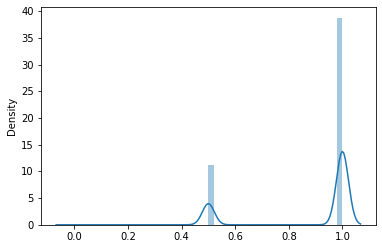

In [9]:
all_rollouts = normalize_rollouts(all_rollouts)

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

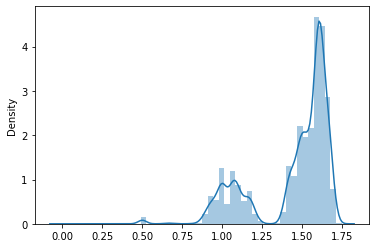

In [10]:
# See what the target q_values look like
# Network has an impact on the q-values
nfq_net = ContrastiveNFQNetwork(state_dim=63, is_contrastive=True)
if is_contrastive:
    optimizer = optim.SGD(itertools.chain(nfq_net.layers_shared.parameters(), nfq_net.layers_last_shared.parameters()), lr=1e-3)
else:
    optimizer = optim.SGD(nfq_net.parameters(), lr=5e-3)
nfq_agent = NFQAgent(nfq_net, optimizer)
state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts)
sns.distplot(target_q_values)

 36%|███▋      | 728/2001 [39:00<27:33,  1.30s/it]  

BG Converged


 36%|███▋      | 729/2001 [39:01<27:29,  1.30s/it]

BG Converged


 36%|███▋      | 730/2001 [39:03<27:41,  1.31s/it]

BG Converged


 37%|███▋      | 731/2001 [39:04<27:29,  1.30s/it]

BG Converged


 37%|███▋      | 732/2001 [39:05<27:38,  1.31s/it]

BG Converged


 37%|███▋      | 733/2001 [39:06<27:16,  1.29s/it]

BG Converged


 37%|███▋      | 734/2001 [39:08<27:27,  1.30s/it]

BG Converged


 37%|███▋      | 735/2001 [39:09<27:36,  1.31s/it]

BG Converged


 37%|███▋      | 736/2001 [39:10<27:08,  1.29s/it]

BG Converged


 37%|███▋      | 737/2001 [39:12<27:29,  1.30s/it]

BG Converged


 37%|███▋      | 738/2001 [39:13<27:34,  1.31s/it]

BG Converged


 37%|███▋      | 739/2001 [39:14<26:59,  1.28s/it]

BG Converged


 37%|███▋      | 740/2001 [39:16<27:10,  1.29s/it]

BG Converged


 37%|███▋      | 741/2001 [39:17<26:45,  1.27s/it]

BG Converged


 37%|███▋      | 742/2001 [39:18<26:55,  1.28s/it]

BG Converged


 37%|███▋      | 743/2001 [39:19<26:32,  1.27s/it]

BG Converged


 37%|███▋      | 744/2001 [39:21<26:41,  1.27s/it]

BG Converged


 37%|███▋      | 745/2001 [39:22<26:55,  1.29s/it]

BG Converged


 37%|███▋      | 746/2001 [39:23<26:33,  1.27s/it]

BG Converged


 37%|███▋      | 747/2001 [39:24<26:45,  1.28s/it]

BG Converged


 37%|███▋      | 748/2001 [39:26<27:04,  1.30s/it]

BG Converged


 37%|███▋      | 749/2001 [39:27<26:40,  1.28s/it]

BG Converged


 37%|███▋      | 750/2001 [39:28<26:55,  1.29s/it]

BG Converged


 38%|███▊      | 751/2001 [39:30<26:27,  1.27s/it]

BG Converged


 38%|███▊      | 752/2001 [39:31<26:38,  1.28s/it]

BG Converged


 38%|███▊      | 753/2001 [39:32<26:29,  1.27s/it]

BG Converged


 38%|███▊      | 754/2001 [39:33<26:40,  1.28s/it]

BG Converged


 38%|███▊      | 755/2001 [39:35<26:44,  1.29s/it]

BG Converged


 38%|███▊      | 756/2001 [39:36<26:25,  1.27s/it]

BG Converged


 38%|███▊      | 757/2001 [39:37<26:35,  1.28s/it]

BG Converged
FREEZING SHARED


 38%|███▊      | 758/2001 [39:39<26:39,  1.29s/it]

BG Converged


 38%|███▊      | 759/2001 [39:40<26:15,  1.27s/it]

BG Converged


 38%|███▊      | 760/2001 [39:41<26:30,  1.28s/it]

BG Converged


 38%|███▊      | 761/2001 [39:42<26:11,  1.27s/it]

BG Converged


 38%|███▊      | 762/2001 [39:44<26:33,  1.29s/it]

BG Converged


 38%|███▊      | 763/2001 [39:45<26:16,  1.27s/it]

BG Converged


 38%|███▊      | 764/2001 [39:46<26:28,  1.28s/it]

BG Converged


 38%|███▊      | 765/2001 [39:48<26:46,  1.30s/it]

BG Converged


 38%|███▊      | 766/2001 [39:49<26:23,  1.28s/it]

BG Converged


 38%|███▊      | 767/2001 [39:50<26:36,  1.29s/it]

BG Converged


 38%|███▊      | 768/2001 [39:51<26:46,  1.30s/it]

BG Converged


 38%|███▊      | 769/2001 [39:53<26:19,  1.28s/it]

BG Converged


 38%|███▊      | 770/2001 [39:54<26:35,  1.30s/it]

BG Converged


 39%|███▊      | 771/2001 [39:55<26:12,  1.28s/it]

BG Converged


 39%|███▊      | 772/2001 [39:57<26:23,  1.29s/it]

BG Converged


 39%|███▊      | 773/2001 [39:58<26:05,  1.28s/it]

BG Converged


 39%|███▊      | 774/2001 [39:59<26:21,  1.29s/it]

BG Converged


 39%|███▊      | 775/2001 [40:00<26:33,  1.30s/it]

BG Converged


 39%|███▉      | 776/2001 [40:02<26:23,  1.29s/it]

BG Converged


 39%|███▉      | 777/2001 [40:03<26:37,  1.31s/it]

BG Converged


 39%|███▉      | 778/2001 [40:04<26:43,  1.31s/it]

BG Converged


 39%|███▉      | 779/2001 [40:06<26:12,  1.29s/it]

BG Converged


 39%|███▉      | 780/2001 [40:07<26:14,  1.29s/it]

BG Converged


 39%|███▉      | 781/2001 [40:08<25:51,  1.27s/it]

BG Converged


 39%|███▉      | 782/2001 [40:09<26:05,  1.28s/it]

BG Converged


 39%|███▉      | 783/2001 [40:11<25:39,  1.26s/it]

BG Converged


 39%|███▉      | 784/2001 [40:12<25:55,  1.28s/it]

BG Converged


 39%|███▉      | 785/2001 [40:13<26:13,  1.29s/it]

BG Converged


 39%|███▉      | 786/2001 [40:15<25:43,  1.27s/it]

BG Converged


 39%|███▉      | 787/2001 [40:16<25:52,  1.28s/it]

BG Converged


 39%|███▉      | 788/2001 [40:17<26:05,  1.29s/it]

BG Converged


 39%|███▉      | 789/2001 [40:18<25:41,  1.27s/it]

BG Converged


 39%|███▉      | 790/2001 [40:20<25:52,  1.28s/it]

BG Converged


 40%|███▉      | 791/2001 [40:21<25:18,  1.25s/it]

BG Converged


 40%|███▉      | 792/2001 [40:22<25:22,  1.26s/it]

BG Converged


 40%|███▉      | 793/2001 [40:23<25:02,  1.24s/it]

BG Converged


 40%|███▉      | 794/2001 [40:25<25:21,  1.26s/it]

BG Converged


 40%|███▉      | 795/2001 [40:26<25:35,  1.27s/it]

BG Converged


 40%|███▉      | 796/2001 [40:27<25:17,  1.26s/it]

BG Converged


 40%|███▉      | 797/2001 [40:28<25:36,  1.28s/it]

BG Converged


 40%|███▉      | 798/2001 [40:30<25:47,  1.29s/it]

BG Converged


 40%|███▉      | 799/2001 [40:31<25:42,  1.28s/it]

BG Converged


 40%|███▉      | 800/2001 [40:32<25:53,  1.29s/it]

BG Converged


 40%|████      | 801/2001 [40:34<25:27,  1.27s/it]

BG Converged


 40%|████      | 802/2001 [40:35<25:45,  1.29s/it]

BG Converged


 40%|████      | 803/2001 [40:36<25:21,  1.27s/it]

BG Converged


 40%|████      | 804/2001 [40:37<25:25,  1.27s/it]

BG Converged


 40%|████      | 805/2001 [40:39<25:38,  1.29s/it]

BG Converged


 40%|████      | 806/2001 [40:40<25:18,  1.27s/it]

BG Converged


 40%|████      | 807/2001 [40:41<25:33,  1.28s/it]

BG Converged


 40%|████      | 808/2001 [40:43<25:46,  1.30s/it]

BG Converged


 40%|████      | 809/2001 [40:44<25:24,  1.28s/it]

BG Converged


 40%|████      | 810/2001 [40:45<25:31,  1.29s/it]

BG Converged


 41%|████      | 811/2001 [40:46<25:13,  1.27s/it]

BG Converged


 41%|████      | 812/2001 [40:48<25:28,  1.29s/it]

BG Converged


 41%|████      | 813/2001 [40:49<25:03,  1.27s/it]

BG Converged


 41%|████      | 814/2001 [40:50<25:13,  1.27s/it]

BG Converged


 41%|████      | 815/2001 [40:52<25:24,  1.29s/it]

BG Converged


 41%|████      | 816/2001 [40:53<25:00,  1.27s/it]

BG Converged


 41%|████      | 817/2001 [40:54<25:26,  1.29s/it]

BG Converged


 41%|████      | 818/2001 [40:55<25:47,  1.31s/it]

BG Converged


 41%|████      | 819/2001 [40:57<25:29,  1.29s/it]

BG Converged


 41%|████      | 820/2001 [40:58<25:36,  1.30s/it]

BG Converged


 41%|████      | 821/2001 [40:59<25:17,  1.29s/it]

BG Converged


 41%|████      | 822/2001 [41:01<25:40,  1.31s/it]

BG Converged


 45%|████▌     | 904/2001 [42:47<23:34,  1.29s/it]

BG Converged


 45%|████▌     | 905/2001 [42:49<23:43,  1.30s/it]

BG Converged


 45%|████▌     | 906/2001 [42:50<23:16,  1.28s/it]

BG Converged


 45%|████▌     | 907/2001 [42:51<23:28,  1.29s/it]

BG Converged


 45%|████▌     | 908/2001 [42:52<23:39,  1.30s/it]

BG Converged


 45%|████▌     | 909/2001 [42:54<23:29,  1.29s/it]

BG Converged


 45%|████▌     | 910/2001 [42:55<23:52,  1.31s/it]

BG Converged


 46%|████▌     | 911/2001 [42:56<23:36,  1.30s/it]

BG Converged


 46%|████▌     | 912/2001 [42:58<23:47,  1.31s/it]

BG Converged


 46%|████▌     | 913/2001 [42:59<23:21,  1.29s/it]

BG Converged


 46%|████▌     | 914/2001 [43:00<23:33,  1.30s/it]

BG Converged


 46%|████▌     | 915/2001 [43:02<23:48,  1.32s/it]

BG Converged


 46%|████▌     | 916/2001 [43:03<23:22,  1.29s/it]

BG Converged


 46%|████▌     | 917/2001 [43:04<23:23,  1.29s/it]

BG Converged


 46%|████▌     | 918/2001 [43:05<23:26,  1.30s/it]

BG Converged


 46%|████▌     | 919/2001 [43:07<22:57,  1.27s/it]

BG Converged


 46%|████▌     | 920/2001 [43:08<23:10,  1.29s/it]

BG Converged


 46%|████▌     | 921/2001 [43:09<22:49,  1.27s/it]

BG Converged


 46%|████▌     | 922/2001 [43:10<23:03,  1.28s/it]

BG Converged


 46%|████▌     | 923/2001 [43:12<22:45,  1.27s/it]

BG Converged


 46%|████▌     | 924/2001 [43:13<22:58,  1.28s/it]

BG Converged


 46%|████▌     | 925/2001 [43:14<23:11,  1.29s/it]

BG Converged


 46%|████▋     | 926/2001 [43:16<22:45,  1.27s/it]

BG Converged


 46%|████▋     | 927/2001 [43:17<22:53,  1.28s/it]

BG Converged


 46%|████▋     | 928/2001 [43:18<23:04,  1.29s/it]

BG Converged


 46%|████▋     | 929/2001 [43:19<22:40,  1.27s/it]

BG Converged


 46%|████▋     | 930/2001 [43:21<22:50,  1.28s/it]

BG Converged


 47%|████▋     | 931/2001 [43:22<22:30,  1.26s/it]

BG Converged


 47%|████▋     | 932/2001 [43:23<22:43,  1.28s/it]

BG Converged


 47%|████▋     | 933/2001 [43:24<22:30,  1.26s/it]

BG Converged


 47%|████▋     | 934/2001 [43:26<22:50,  1.28s/it]

BG Converged


 47%|████▋     | 935/2001 [43:27<23:00,  1.29s/it]

BG Converged


 47%|████▋     | 936/2001 [43:28<22:34,  1.27s/it]

BG Converged


 47%|████▋     | 937/2001 [43:30<22:51,  1.29s/it]

BG Converged


 47%|████▋     | 938/2001 [43:31<23:14,  1.31s/it]

BG Converged


 47%|████▋     | 939/2001 [43:32<22:46,  1.29s/it]

BG Converged


 47%|████▋     | 940/2001 [43:34<22:53,  1.29s/it]

BG Converged


 47%|████▋     | 941/2001 [43:35<22:33,  1.28s/it]

BG Converged


 47%|████▋     | 942/2001 [43:36<22:37,  1.28s/it]

BG Converged


 47%|████▋     | 943/2001 [43:37<22:18,  1.27s/it]

BG Converged


 47%|████▋     | 944/2001 [43:39<22:32,  1.28s/it]

BG Converged


 47%|████▋     | 945/2001 [43:40<22:41,  1.29s/it]

BG Converged


 47%|████▋     | 946/2001 [43:41<22:15,  1.27s/it]

BG Converged


 47%|████▋     | 947/2001 [43:42<22:23,  1.27s/it]

BG Converged


 47%|████▋     | 948/2001 [43:44<22:32,  1.28s/it]

BG Converged


 47%|████▋     | 949/2001 [43:45<22:12,  1.27s/it]

BG Converged


 47%|████▋     | 950/2001 [43:46<22:27,  1.28s/it]

BG Converged


 48%|████▊     | 951/2001 [43:48<22:07,  1.26s/it]

BG Converged


 48%|████▊     | 952/2001 [43:49<22:21,  1.28s/it]

BG Converged


 48%|████▊     | 953/2001 [43:50<22:02,  1.26s/it]

BG Converged


 48%|████▊     | 954/2001 [43:51<22:13,  1.27s/it]

BG Converged


 48%|████▊     | 955/2001 [43:53<22:20,  1.28s/it]

BG Converged


 48%|████▊     | 956/2001 [43:54<22:15,  1.28s/it]

BG Converged


 48%|████▊     | 957/2001 [43:55<22:39,  1.30s/it]

BG Converged


 48%|████▊     | 958/2001 [43:57<22:59,  1.32s/it]

BG Converged


 48%|████▊     | 959/2001 [43:58<22:44,  1.31s/it]

BG Converged


 48%|████▊     | 960/2001 [43:59<22:46,  1.31s/it]

BG Converged


 48%|████▊     | 961/2001 [44:00<22:24,  1.29s/it]

BG Converged


 48%|████▊     | 962/2001 [44:02<22:47,  1.32s/it]

BG Converged


 48%|████▊     | 963/2001 [44:03<22:21,  1.29s/it]

BG Converged


 48%|████▊     | 964/2001 [44:04<22:26,  1.30s/it]

BG Converged


 48%|████▊     | 965/2001 [44:06<22:34,  1.31s/it]

BG Converged


 48%|████▊     | 966/2001 [44:07<22:13,  1.29s/it]

BG Converged


 48%|████▊     | 967/2001 [44:08<22:25,  1.30s/it]

BG Converged


 48%|████▊     | 968/2001 [44:10<22:31,  1.31s/it]

BG Converged


 48%|████▊     | 969/2001 [44:11<22:07,  1.29s/it]

BG Converged


 48%|████▊     | 970/2001 [44:12<22:20,  1.30s/it]

BG Converged


 49%|████▊     | 971/2001 [44:13<22:00,  1.28s/it]

BG Converged


 49%|████▊     | 972/2001 [44:15<22:19,  1.30s/it]

BG Converged


 49%|████▊     | 973/2001 [44:16<22:02,  1.29s/it]

BG Converged


 49%|████▊     | 974/2001 [44:17<22:16,  1.30s/it]

BG Converged


 49%|████▊     | 975/2001 [44:19<22:25,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 976/2001 [44:20<22:01,  1.29s/it]

BG Converged
FG Converged


 49%|████▉     | 977/2001 [44:21<22:09,  1.30s/it]

BG Converged
FG Converged


 49%|████▉     | 978/2001 [44:23<22:16,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 979/2001 [44:24<22:00,  1.29s/it]

BG Converged
FG Converged


 49%|████▉     | 980/2001 [44:25<22:08,  1.30s/it]

BG Converged
FG Converged


 49%|████▉     | 981/2001 [44:26<22:02,  1.30s/it]

BG Converged
FG Converged


 49%|████▉     | 982/2001 [44:28<22:17,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 983/2001 [44:29<21:58,  1.30s/it]

BG Converged
FG Converged


 49%|████▉     | 984/2001 [44:30<22:07,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 985/2001 [44:32<22:29,  1.33s/it]

BG Converged
FG Converged


 49%|████▉     | 986/2001 [44:33<22:03,  1.30s/it]

BG Converged
FG Converged


 49%|████▉     | 987/2001 [44:34<22:04,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 988/2001 [44:36<22:04,  1.31s/it]

BG Converged
FG Converged


 49%|████▉     | 989/2001 [44:37<21:41,  1.29s/it]

BG Converged
FG Converged


 49%|████▉     | 990/2001 [44:38<21:53,  1.30s/it]

BG Converged
FG Converged


 50%|████▉     | 991/2001 [44:39<21:29,  1.28s/it]

BG Converged
FG Converged


 50%|████▉     | 992/2001 [44:41<21:37,  1.29s/it]

BG Converged
FG Converged


 50%|████▉     | 993/2001 [44:42<21:19,  1.27s/it]

BG Converged
FG Converged


 50%|████▉     | 994/2001 [44:43<21:33,  1.28s/it]

BG Converged
FG Converged


 50%|████▉     | 995/2001 [44:45<21:41,  1.29s/it]

BG Converged
FG Converged


 50%|████▉     | 996/2001 [44:46<21:18,  1.27s/it]

BG Converged
FG Converged


 50%|████▉     | 997/2001 [44:47<21:23,  1.28s/it]

BG Converged
FG Converged


 50%|████▉     | 998/2001 [44:48<21:26,  1.28s/it]

BG Converged
FG Converged


 50%|████▉     | 999/2001 [44:50<21:03,  1.26s/it]

BG Converged
FG Converged


 50%|████▉     | 1000/2001 [44:51<21:14,  1.27s/it]

BG Converged
FG Converged


 50%|█████     | 1001/2001 [44:52<20:57,  1.26s/it]

BG Converged
FG Converged


 50%|█████     | 1002/2001 [44:53<21:14,  1.28s/it]

BG Converged
FG Converged


 50%|█████     | 1003/2001 [44:55<20:57,  1.26s/it]

BG Converged
FG Converged


 50%|█████     | 1004/2001 [44:56<21:13,  1.28s/it]

BG Converged
FG Converged


 50%|█████     | 1005/2001 [44:57<21:26,  1.29s/it]

BG Converged
FG Converged


 50%|█████     | 1006/2001 [44:59<21:10,  1.28s/it]

BG Converged
FG Converged


 50%|█████     | 1007/2001 [45:00<21:20,  1.29s/it]

BG Converged
FG Converged


 50%|█████     | 1008/2001 [45:01<21:40,  1.31s/it]

BG Converged
FG Converged


 50%|█████     | 1009/2001 [45:03<21:18,  1.29s/it]

BG Converged
FG Converged


 50%|█████     | 1010/2001 [45:04<21:27,  1.30s/it]

BG Converged
FG Converged


 51%|█████     | 1011/2001 [45:05<21:08,  1.28s/it]

BG Converged
FG Converged


 51%|█████     | 1012/2001 [45:06<21:16,  1.29s/it]

BG Converged
FG Converged


 51%|█████     | 1013/2001 [45:08<21:01,  1.28s/it]

BG Converged
FG Converged


 51%|█████     | 1014/2001 [45:09<21:13,  1.29s/it]

BG Converged
FG Converged


 51%|█████     | 1015/2001 [45:10<21:19,  1.30s/it]

BG Converged
FG Converged


 51%|█████     | 1016/2001 [45:11<20:59,  1.28s/it]

BG Converged
FG Converged


 51%|█████     | 1017/2001 [45:13<21:09,  1.29s/it]

BG Converged
FG Converged


 51%|█████     | 1018/2001 [45:14<21:11,  1.29s/it]

BG Converged
FG Converged


 51%|█████     | 1019/2001 [45:15<20:47,  1.27s/it]

BG Converged
FG Converged


 51%|█████     | 1020/2001 [45:17<20:58,  1.28s/it]

BG Converged
FG Converged


 51%|█████     | 1021/2001 [45:18<20:41,  1.27s/it]

BG Converged
FG Converged


 51%|█████     | 1022/2001 [45:19<20:45,  1.27s/it]

BG Converged
FG Converged


 51%|█████     | 1023/2001 [45:20<20:26,  1.25s/it]

BG Converged
FG Converged


 51%|█████     | 1023/2001 [45:22<43:22,  2.66s/it]

BG Converged
FG Converged


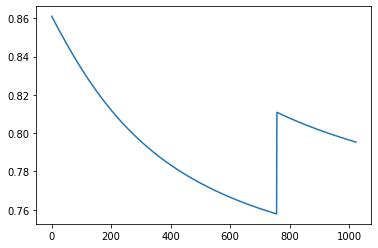

In [11]:
# Setup agent
nfq_net = ContrastiveNFQNetwork(state_dim=63, is_contrastive=True)
optimizer = optim.SGD(itertools.chain(nfq_net.layers_shared.parameters(), nfq_net.layers_last_shared.parameters()), lr=5e-4)

nfq_agent = NFQAgent(nfq_net, optimizer)
previous_loss = None
delta = 5e-5
count_fg = 0
count_bg = 0
bg_converged = False
fg_converged = False

losses = []
epoch = 2000
for k, epoch in enumerate(tqdm.tqdm(range(epoch + 1))):

    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts)

    loss = nfq_agent.train((state_action_b, target_q_values, groups))
    
    if previous_loss is not None:
        if abs(previous_loss - loss) < delta:
            if not nfq_net.freeze_shared:
                bg_converged = True
            else:
                fg_converged = True
    previous_loss = loss
    losses.append(loss)
    
    if is_contrastive:
        if nfq_net.freeze_shared:
            for param in nfq_net.layers_fg.parameters():
                assert param.requires_grad == True
            for param in nfq_net.layers_last_fg.parameters():
                assert param.requires_grad == True
            for param in nfq_net.layers_shared.parameters():
                assert param.requires_grad == False
            for param in nfq_net.layers_last_shared.parameters():
                assert param.requires_grad == False
        else:

            for param in nfq_net.layers_fg.parameters():
                assert param.requires_grad == False
            for param in nfq_net.layers_last_fg.parameters():
                assert param.requires_grad == False
            for param in nfq_net.layers_shared.parameters():
                assert param.requires_grad == True
            for param in nfq_net.layers_last_shared.parameters():
                assert param.requires_grad == True
    
    if bg_converged:
        count_bg += 1
        print("BG Converged")
    if bg_converged and count_bg == 30:
        nfq_net.freeze_shared = True
        if verbose:
            print("FREEZING SHARED")
        if is_contrastive:
            for param in nfq_net.layers_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = True
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = True

            optimizer = optim.SGD(itertools.chain(nfq_net.layers_fg.parameters(), nfq_net.layers_last_fg.parameters()), lr=5e-4)
            nfq_agent._optimizer = optimizer

    if fg_converged:
        if verbose:
            print("FG Converged")
        count_fg += 1
    
    if count_fg == 50:
        break

    
    
plt.plot(losses)    
    
    



# Evaluation
* The optimal levels for K are between 3.5 and 4.5

In [ ]:
def state_invtransformer(tstates, transformer='transformer.pkl'):
    
    scaler = pickle.load(open(transformer, 'rb'))
    states = scaler.inverse_transform(tstates)
    
    return states

In [ ]:
state_feats = ['anchor_age', 'patientweight', 'los', 'gender',
       'cad', 'afib', 'chf', 'ckd', 'renal', 'paralysis', 'parathyroid',
       'rhabdo', 'sarcoid', 'sepsis', 'expired', 'urine', 'bpdia', 'bpsys',
       'hr', 'rr', 'spo2', 'temp', 'alt', 'aniongap', 'bun', 'cpk', 'ca',
       'chloride', 'creatinine', 'glucose', 'hgb', 'k', 'ldh', 'mg', 'na', 'p',
       'wbc', 'betablockers', 'ca-iv', 'ca-noniv', 'cablockers', 'dextrose',
       'fluids', 'insulin', 'k-iv', 'hours-k-iv', 'k-noniv', 'hours-k-noniv',
       'loopdiuretics', 'mg-iv', 'hours-mg-iv', 'mg-noniv', 'hours-mg-noniv',
       'p-iv', 'hours-p-iv', 'p-noniv', 'hours-p-noniv', 'pnutrition',
       'ponutrition', 'tpnutrition', 'vasopressors', 'adm-dialysis',
       'adm-rbc']

In [ ]:
def forward(obs, action, is_contrastive, group, nfq_agent):
    if is_contrastive:
        if group == 0:
            x = nfq_agent._nfq_net.layers_shared(torch.cat([torch.FloatTensor(obs), torch.FloatTensor(a)], dim=0))
            reward = nfq_agent._nfq_net.layers_last_shared(x)
        else:
            x_shared = nfq_agent._nfq_net.layers_shared(torch.cat([torch.FloatTensor(obs), torch.FloatTensor(a)], dim=0))
            x_fg = nfq_agent._nfq_net.layers_fg(torch.cat([torch.FloatTensor(obs), torch.FloatTensor(a)], dim=0))
            x_shared = nfq_agent._nfq_net.layers_last_shared(x_shared)
            x_fg = nfq_agent._nfq_net.layers_last_fg(x_fg)
            reward = x_shared + x_fg
    else:
        reward = nfq_agent._nfq_net(
            torch.cat([torch.FloatTensor(obs), torch.FloatTensor(a)], dim=0), group * torch.ones(1))
    
    return reward

In [ ]:
# Evaluate the difference in rewards at each time step
def evaluate(doctors_actions, policy_actions, states, group, nfq_agent):
    doctor_reward = 0
    policy_reward = 0
    for (doctors_action, policy_action, state) in zip(doctors_actions, policy_actions, states):
        reward_doctor = forward(state, doctors_action, True, group, nfq_agent).detach().cpu().numpy()[0]
        reward_policy = forward(state, policy_action, True, group, nfq_agent).detach().cpu().numpy()[0]
        doctor_reward += reward_doctor
        policy_reward += reward_policy
    
    return policy_reward, doctor_reward - policy_reward

#evaluate(doctors_actions, policy_actions, states, 1, nfq_agent)

In [ ]:
all_d_actions = []
all_p_actions = []
network_output = []

In [ ]:
reward_deltas = []
for vn in renal_test_tuples['vnum']:
    rollout = generate_rollout(vn, renal_test_tuples, group=1)
    states = [r[0] for r in rollout]
    doctors_actions = [r[1] for r in rollout]
    all_d_actions.extend(doctors_actions)
    actions = np.asarray([[0, 0], [0, 10], [10, 0]])
    policy_actions = []
    for s in states:
        a = nfq_agent.get_best_action(s, actions, group=1)
        policy_actions.append(list(a))
    
    all_p_actions.extend(policy_actions)
    
    output, delta = evaluate(doctors_actions, policy_actions, states, 1, nfq_agent)
    reward_deltas.append(delta)
    network_output.append(output)
sns.distplot(reward_deltas)
plt.title("Difference in Foreground Group")

In [ ]:
sns.distplot(network_output)

In [ ]:
for vn in renal_train_tuples['vnum']:
    rollout = generate_rollout(vn, renal_train_tuples, group=1)
    states = [r[0] for r in rollout]
    doctors_actions = [r[1] for r in rollout]
    all_d_actions.extend(doctors_actions)
    actions = np.asarray([[0, 0], [0, 10], [10, 0]])
    policy_actions = []
    for s in states:
        a = nfq_agent.get_best_action(s, actions, group=1)
        policy_actions.append(list(a))
    
    output, delta = evaluate(doctors_actions, policy_actions, states, 1, nfq_agent)
    print("Network output: ", output)
    print("Reward delta; ", delta)

    

## Actions

# Heatmap of Actions

In [ ]:
def gather_repletion_levels(doctor=False, renal=False, num_samples=1000):
    no_repletion = []
    lo_repletion = []
    hi_repletion = []
    c_levels = []
    if renal:
        tuples = renal_test_tuples
        group = 1
    else:
        tuples=regular_test_tuples
        group = 0
    for j, vn in enumerate(tqdm.tqdm(tuples['vnum'][:num_samples])):
        rollout = generate_rollout(vn, tuples, group=group)
        states = [r[0] for r in rollout]
        k_measurement_ind = state_feats.index('k')
        c_ind = state_feats.index('creatinine')
        doctors_actions = [r[1] for r in rollout]
        actions = np.asarray([[0, 0], [0, 10], [10, 0]])
        for s in states:
            transformed_state = state_invtransformer(s)
            k = transformed_state[k_measurement_ind]
            creatinine = transformed_state[c_ind]
            c_levels.append(creatinine)
            a = nfq_agent.get_best_action(s, actions, group=group)
            a = list(a)
            if a == [0, 0]:
                no_repletion.append((creatinine, k))
            elif a == [0, 10]:
                lo_repletion.append((creatinine, k))
            elif a == [10, 0]:
                hi_repletion.append((creatinine, k))
    c_levels = [i for i in range(0, 11)]
    measurements = [i/10 for i in range(26, 75)]
    viz = np.zeros((len(c_levels), len(measurements)))
    counts = np.zeros((len(c_levels), len(measurements)))
    for (c, measurement) in no_repletion:
        measurement = round(measurement, 1)
        c = round(c, 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 0
        counts[c, new_meas] += 1
    for (c, measurement) in lo_repletion:
        measurement = round(measurement, 1)
        c = round(c, 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 1
        counts[c, new_meas] += 1
    for (c, measurement) in hi_repletion:
        measurement = round(measurement, 1)
        c = round(c, 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 2
        counts[c, new_meas] += 1

    viz = np.divide(viz, counts, out=np.full_like(viz, np.nan), where=counts!=0)
    return viz, measurements, c_levels

In [ ]:
viz, measurements, ages = gather_repletion_levels(renal=False)
plt.figure(figsize=(14, 5))
sns.heatmap(viz, xticklabels=measurements, yticklabels=ages)
plt.ylabel("Creatinine")
plt.xlabel("Potassium Level in Blood (mmol/L)")
plt.title("Evaluating Regular Patients")
viz, measurements, ages = gather_repletion_levels(renal=True)
plt.figure(figsize=(14, 5))
sns.heatmap(viz, xticklabels=measurements, yticklabels=ages)
plt.ylabel("Creatinine")
plt.xlabel("Potassium Level in Blood (mmol/L)")
plt.title("Evaluating Renal Patients")

# SHAP plots

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


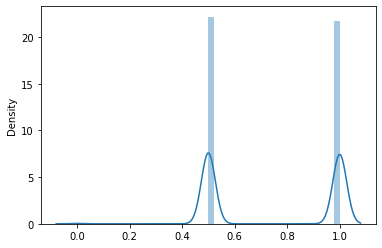

In [12]:
import shap
state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts)
X = (state_action_b, target_q_values)

bg_rollouts = rollout_dataset(ds='test', env='bg', init_experience=init_experience)
fg_rollouts = rollout_dataset(ds='test', env='fg', init_experience=init_experience)
bg_rollouts.extend(fg_rollouts)
all_rollouts = bg_rollouts.copy()
all_rollouts = normalize_rollouts(all_rollouts)
state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(all_rollouts)
X_test = (state_action_b, target_q_values)

Text(0.5, 1.0, 'Shap Values: Foreground')

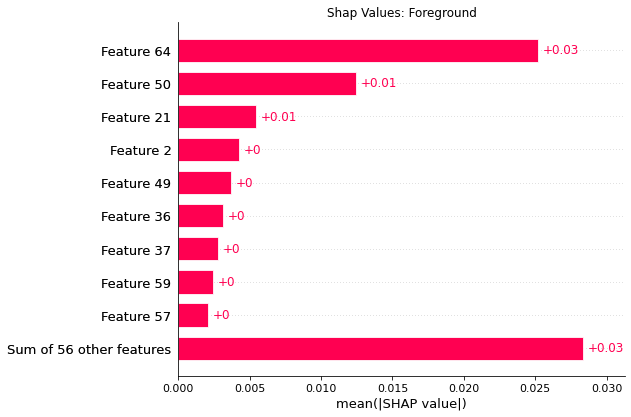

In [14]:
group_0 = []
group_1 = []
for x, g in zip(X_test[0], X_test[1]):
    if g == 0:
        group_0.append(x.cpu().detach().numpy())
    else:
        group_1.append(x.cpu().detach().numpy())
group_0 = torch.Tensor(np.asarray(group_0))
group_1 = torch.Tensor(np.asarray(group_1))
e = shap.DeepExplainer(nfq_agent._nfq_net, X[0])
shap_values = e.shap_values(group_1[:10])
explanation = shap.Explanation(shap_values)
shap.plots.bar(shap.Explanation(shap_values), show=False)
plt.title("Shap Values: Foreground")